In [1]:
"""
These were (shamelessly) taken from cs231n course github code.
I believe these were coded by Andrej Karpathy so credit goes to him
for coding these.
"""

import numpy as np
import matplotlib.pyplot as plt


def create_dataset(N, D=2, K=2):
    X = np.zeros((N * K, D))  # data matrix (each row = single example)
    y = np.zeros(N * K)  # class labels

    for j in range(K):
        ix = range(N * j, N * (j + 1))
        r = np.linspace(0.0, 1, N)  # radius
        t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2  # theta
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix] = j

    # lets visualize the data:
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.show()

    y[y == 0] -= 1

    return X, y

def create_dataset_linear_two_labels(N, D=2, K=2):
    X = np.zeros((N * K, D))  # data matrix (each row = single example)
    y = np.zeros(N * K)  # class labels

    for j in range(K):
        ix = range(N * j, N * (j + 1))
        r = 10 + np.random.randn(N) * 0.5 # radius
        t = np.random.randn(N) * 0.2  # theta
        if(j == 0):
            h = -1
        else:
            h = 1
                
        X[ix] = np.c_[r*np.cos(t), r*np.sin(t)]*h
        y[ix] = j

    # lets visualize the data:
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.show()

    y[y == 0] -= 1

    return X, y

def create_dataset_islands_two_labels(N, D=2, K=2):
    X = np.zeros((N * K, D))  # data matrix (each row = single example)
    y = np.zeros(N * K)  # class labels

    for j in range(K):
        ix = range(N * j, N * (j + 1))
        t = np.linspace(0, 2*np.pi, N) + np.random.randn(N) * 0.2 
        if(j == 0):
            r = 10 + np.random.randn(N) * 0.5 # radius
        else:
            r = 4 + np.random.randn(N) * 0.5 # radius
                
        X[ix] = np.c_[r*np.cos(t), r*np.sin(t)]
        y[ix] = j

    # lets visualize the data:
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.show()

    y[y == 0] -= 1

    return X, y



def plot_contour(X, y, svm):
    # plot the resulting classifier
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    points = np.c_[xx.ravel(), yy.ravel()]

    Z = svm.predict(points)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)

    # plt the points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.show()

In [2]:
import numpy as np
import cvxopt

def linear(x, z):
    return np.dot(x, z.T)

def polynomial(x, z, p=5):
    return (1 + np.dot(x, z.T)) ** p

def gaussian(x, z, sigma=0.5):
    return np.exp(-np.linalg.norm(x - z, axis=1) ** 2 / (2 * (sigma ** 2)))

def sigmoid(x, z, c):
    pass

class SVM:
    def __init__(self, kernel=gaussian, C=1):
        self.kernel = kernel
        self.C = C

    def fit(self, X, y):
        self.y = y
        self.X = X
        m, n = X.shape

        # Calculate Kernel
        self.K = np.zeros((m, m))
        for i in range(m):
            self.K[i, :] = self.kernel(X[i, np.newaxis], self.X)

        # Solve with cvxopt final QP needs to be reformulated
        # to match the input form for cvxopt.solvers.qp
        P = cvxopt.matrix(np.outer(y, y) * self.K)
        q = cvxopt.matrix(-np.ones((m, 1)))
        G = cvxopt.matrix(np.vstack((np.eye(m) * -1, np.eye(m))))
        h = cvxopt.matrix(np.hstack((np.zeros(m), np.ones(m) * self.C)))
        A = cvxopt.matrix(y, (1, m), "d")
        b = cvxopt.matrix(np.zeros(1))
        cvxopt.solvers.options["show_progress"] = True
        sol = cvxopt.solvers.qp(P, q, G, h, A, b)
        self.alphas = np.array(sol["x"])

    def predict(self, X):
        y_predict = np.zeros((X.shape[0]))
        sv = self.get_parameters(self.alphas)

        for i in range(X.shape[0]):
            y_predict[i] = np.sum(
                self.alphas[sv]
                * self.y[sv, np.newaxis]
                * self.kernel(X[i], self.X[sv])[:, np.newaxis]
            )

        return np.sign(y_predict + self.b)

    def get_parameters(self, alphas):
        threshold = 1e-5

        sv = ((alphas > threshold) * (alphas < self.C)).flatten()
        self.w = np.dot(X[sv].T, alphas[sv] * self.y[sv, np.newaxis])
        self.b = np.mean(
            self.y[sv, np.newaxis]
            - self.alphas[sv] * self.y[sv, np.newaxis] * self.K[sv, sv][:, np.newaxis]
        )
        return sv

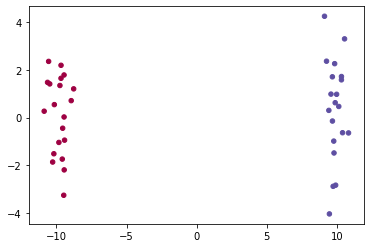

     pcost       dcost       gap    pres   dres
 0: -9.7598e-02 -4.4320e+01  2e+02  2e+00  8e-15
 1: -2.2717e-02 -1.3596e+01  2e+01  6e-02  4e-15
 2:  1.5328e-02 -2.4523e-01  3e-01  7e-04  2e-15
 3: -1.9395e-03 -1.9377e-02  2e-02  7e-06  4e-16
 4: -5.3246e-03 -6.9825e-03  2e-03  1e-16  3e-16
 5: -5.6495e-03 -6.3700e-03  7e-04  2e-16  1e-16
 6: -6.0222e-03 -6.3471e-03  3e-04  2e-16  2e-16
 7: -6.1608e-03 -6.1986e-03  4e-05  2e-16  2e-16
 8: -6.1774e-03 -6.1778e-03  4e-07  2e-16  2e-16
 9: -6.1776e-03 -6.1776e-03  4e-09  2e-16  2e-16
Optimal solution found.


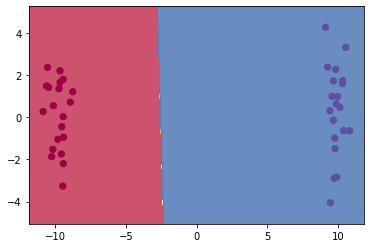

Accuracy: 1.0


In [9]:
np.random.seed(1)
X, y = create_dataset_linear_two_labels(N=20, K=2)

svm = SVM(kernel=linear)
svm.fit(X, y)
y_pred = svm.predict(X)
plot_contour(X, y, svm)

print(f"Accuracy: {sum(y==y_pred)/y.shape[0]}")

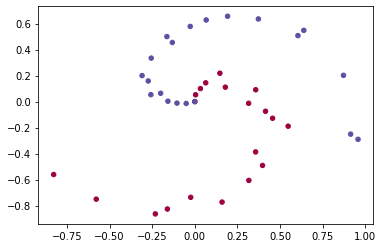

     pcost       dcost       gap    pres   dres
 0: -9.7378e+00 -6.3865e+01  2e+02  2e+00  2e-15
 1: -7.9641e+00 -3.3683e+01  3e+01  5e-02  1e-15
 2: -9.7573e+00 -1.3419e+01  4e+00  6e-03  1e-15
 3: -1.0698e+01 -1.1473e+01  8e-01  1e-03  1e-15
 4: -1.0879e+01 -1.1087e+01  2e-01  3e-04  1e-15
 5: -1.0950e+01 -1.0990e+01  4e-02  3e-05  1e-15
 6: -1.0965e+01 -1.0970e+01  5e-03  2e-06  1e-15
 7: -1.0967e+01 -1.0967e+01  2e-04  4e-08  1e-15
 8: -1.0967e+01 -1.0967e+01  7e-06  5e-10  1e-15
Optimal solution found.


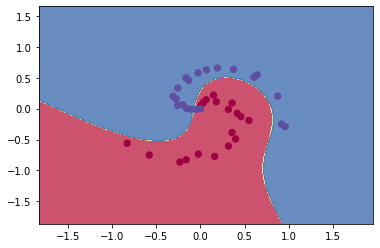

Accuracy: 0.95


In [6]:
np.random.seed(1)
X, y = create_dataset(N=20, K=2)

svm = SVM(kernel=polynomial)
svm.fit(X, y)
y_pred = svm.predict(X)
plot_contour(X, y, svm)

print(f"Accuracy: {sum(y==y_pred)/y.shape[0]}")

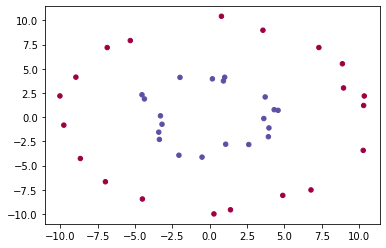

     pcost       dcost       gap    pres   dres
 0: -1.5758e+01 -6.2440e+01  5e+01  2e-15  4e-16
 1: -1.6379e+01 -1.9438e+01  3e+00  5e-15  3e-16
 2: -1.6988e+01 -1.7344e+01  4e-01  2e-15  9e-17
 3: -1.7067e+01 -1.7090e+01  2e-02  4e-15  1e-16
 4: -1.7073e+01 -1.7074e+01  1e-03  2e-16  1e-16
 5: -1.7073e+01 -1.7073e+01  7e-05  3e-15  1e-16
 6: -1.7073e+01 -1.7073e+01  2e-06  3e-15  1e-16
Optimal solution found.


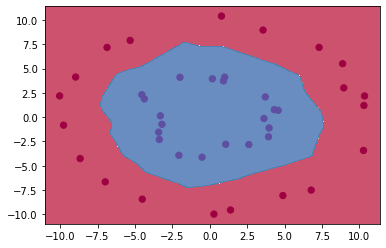

Accuracy: 1.0


In [7]:
np.random.seed(1)
X, y = create_dataset_islands_two_labels(N=20, K=2)

svm = SVM(kernel=gaussian)
svm.fit(X, y)
y_pred = svm.predict(X)
plot_contour(X, y, svm)

print(f"Accuracy: {sum(y==y_pred)/y.shape[0]}")

# Assigment to send by the 22nd of February

Implement the sigmoid kernel and apply it (find an appropiate $c$) to the three data sets above

The sigmoid kernel is $\tanh (X^Ty + c)$